<a href="https://colab.research.google.com/github/Arnab9Codes/PaperWorks-PD/blob/main/Corrected_pd_work_with_scheduler%2088.7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


pip install -r requirements.txt
pip install pipwin
pipwin install -r requirements.txt

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
## Initial Imports

%matplotlib inline

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm_notebook as tqdm

#import lime
#import eli5
#import mlxtend
import warnings
warnings.filterwarnings('ignore')

**`Read data and Display data dimension`**

In [189]:
np.random.seed(10)

In [190]:
#pd_speech_features = pd.read_csv('pd_speech_features.csv')
pd_speech_features = pd.read_csv('/content/drive/My Drive/Paper work/Speech detection/pd_speech_features.csv')
#pd_speech_features = pd.read_csv(os.path.join(dirname,filename))
new_header = pd_speech_features.iloc[0] #grab the first row for the header
pd_speech_features = pd_speech_features[1:] #take the data less the header row
pd_speech_features.columns = new_header #set the header row as the df header
pd_speech_features.head()
print('The shape of the matrix is :', pd_speech_features.shape)

The shape of the matrix is : (756, 755)


#### Gather most general metadata about the data

In [191]:
pd_speech_features.info() # Gives type of columns
pd_speech_features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 1 to 756
Columns: 755 entries, id to class
dtypes: object(755)
memory usage: 4.4+ MB


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,...,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756
unique,252,2,740,745,748,315,319,755,646,358,543,183,244,327,734,547,710,709,722,741,747,748,745,755,755,755,755,755,755,755,755,755,755,754,356,753,380,743,750,735,...,753,754,754,755,754,754,752,754,754,751,752,753,752,754,751,749,741,744,742,742,740,738,746,735,739,732,728,723,735,750,749,755,752,753,749,752,753,753,754,2
top,239,1,0.82273,0.75192,0.70689,237,236,0.006004477,6.29E-05,0.00076,1.39E-05,0.00012,0.00032,0.00036,0.03345,0.376,0.03125,0.05772,0.02824,0.03854,0.972537,0.005904,23.914,80.44328048,85.61022901,82.73382546,769.6772481,1279.806544,3107.527459,3738.070756,76.4915472,117.5349021,192.2014234,503.6803762,1,27.5848,0,0.93829,0.19121,0.13883,...,-3.3736,-0.09052,-8.9141,44.7366,15.7456,13.3637,11.8305,11.6205,11.573,3.5221,3.7508,5.6728,4.6953,11.6165,2.8016,3.2569,2.8667,3.7997,2.4181,2.5715,2.269,2.1762,2.2146,1.5932,1.8336,1.7484,2.3105,1.5899,1.6337,2.3955,3.58,4.0251,4.4021,3.3603,2.3974,3.1144,12.595,3.7708,10.0693,1
freq,3,390,3,2,2,9,8,2,3,9,10,24,14,11,2,5,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,385,2,377,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,3,3,2,3,2,2,2,2,2,2,2,2,2,2,564


In [192]:
pd_speech_features['patient/healthy count'] = 1
pd_speech_features.groupby('class').sum()/3

,patient/healthy count
class,
0,64.0
1,188.0


In [193]:
pd_speech_features = pd_speech_features.drop(['patient/healthy count'], axis = 1)  #756x755

All the data was imported in the object type, we now need to take care about the types in the dataframe

In [194]:
pd_speech_features =  pd_speech_features.astype(float) #per default all floats 
pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']] = pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']].astype(int) #ints
pd_speech_features[['gender', 'class']] = pd_speech_features[['gender', 'class']].astype('category') #categoricals
pd_speech_features.dtypes

0
id                              int64
gender                       category
PPE                           float64
DFA                           float64
RPDE                          float64
                               ...   
tqwt_kurtosisValue_dec_33     float64
tqwt_kurtosisValue_dec_34     float64
tqwt_kurtosisValue_dec_35     float64
tqwt_kurtosisValue_dec_36     float64
class                        category
Length: 755, dtype: object

In [195]:

train_df=pd_speech_features

y_train = train_df['class']
y_train = np.array(y_train.values, dtype = 'int')
x_train = train_df.drop(['class','id'], axis = 1) 

x_train = x_train.values


In [196]:
print(x_train.shape)
print(y_train.shape)


(756, 753)
(756,)


In [197]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [198]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train= sc.fit_transform(x_train)

In [199]:
k_fold=KFold(10,True,10)

In [200]:
import torch.nn as nn
import torch
import torch.nn.functional as F

torch.manual_seed(10)

In [201]:
HU=50
m=nn.Sequential(nn.Linear(HU,HU), nn.ReLU(),nn.Linear(HU,HU),nn.ReLU())

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(753,HU)
        self.l2=nn.Linear(HU,HU)
        self.l3=nn.Linear(HU,HU)
        self.ll=m
        self.l4=nn.Linear(HU,1)
        
    def forward(self,x):
        x=self.l1(x)
        x=F.relu(F.dropout(x,0.20))
        x1=self.l2(x)
        x=self.l3(x1)
        x2=self.ll((x+x1)/2.00)
        x=F.relu(F.dropout((x+x2)/2.0,0.20))
        x=self.ll((x))
        #x=self.l3(x)
        x3=F.relu(F.dropout((x+x1+x2)/3.0,0.200))
        x=self.l4(x3)
        
        return x

In [202]:
#model=lstm_model#Model()
#model=model
model=Model()
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.6,momentum=0.99, nesterov=False)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=(.2))

In [203]:
#x=torch.from_numpy(x_train_transformed_9_features[:600]).float()
x=torch.from_numpy(x_train[:600]).float()
y=torch.from_numpy(y_train[:600]).float()

def train(model,optimizer, scheduler, criterion, x,y):
    
    losses=[]
    
    for i in range(100):
        output=model(x)
        loss=criterion(output.view(y.shape[0]),y)
    
        losses.append(loss)
    
        #if (i%100==0):
         #   print(i,' ',loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # training accuracy
    with torch.no_grad():
        preds=torch.sigmoid(model(x)).round()
        print('\ntraining report: \n',classification_report(y,preds.view(preds.shape[0])))
        
    return model, losses

model, losses= train(model,optimizer, scheduler, criterion,x,y)


training report: 
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       141
         1.0       0.99      1.00      0.99       459

    accuracy                           0.99       600
   macro avg       0.99      0.98      0.98       600
weighted avg       0.99      0.99      0.99       600



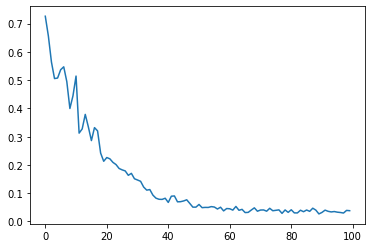

In [204]:
%matplotlib inline
plt.plot(losses)
plt.show()

In [205]:
def test(model, tstx, tsty):
    with torch.no_grad():
    
        preds=torch.sigmoid(model(tstx)).round()
        print('testing report:')
        print(classification_report(tsty,preds.view(preds.shape[0])))
    
    
    
        print(torch.sigmoid(preds).round().shape)

In [206]:
#tstx=torch.from_numpy(x_train_transformed_9_features[600:]).float()
tstx=torch.from_numpy(x_train[600:]).float()
tsty=torch.from_numpy(y_train[600:]).float()

test(model,tstx,tsty)

testing report:
              precision    recall  f1-score   support

         0.0       0.59      0.51      0.55        51
         1.0       0.78      0.83      0.80       105

    accuracy                           0.72       156
   macro avg       0.68      0.67      0.67       156
weighted avg       0.72      0.72      0.72       156

torch.Size([156, 1])


In [207]:
x_train.shape

(756, 753)

In [208]:
def run_network(model, trainx,trainy, testx, testy):
    model=Model()
    criterion = nn.BCEWithLogitsLoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=0.58,momentum=0.99, nesterov=True)
    #optim=torch.optim.Adam(model.parameters(),lr=0.1)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
    model, losses= train(model,optimizer, scheduler, criterion,trainx, trainy)
    test(model, testx, testy)
    
    return model, losses

In [209]:
fold=0
losses=[[] for i in range(10)]

for trids, tstids in k_fold.split(x_train):
    trainx, testx=x_train[trids,:], x_train[tstids,:]
    #trainx, testx=x_train[trids,:], x_train[tstids,:]
    trainy, testy=y_train[trids], y_train[tstids]
    
    trainx=torch.from_numpy(trainx).float()
    trainy=torch.from_numpy(trainy).float()
    testx=torch.from_numpy(testx).float()
    testy=torch.from_numpy(testy).float()
    
    print('fold: ',fold)
    
    model=Model()
    
    _,losses[fold]=run_network(model, trainx,trainy, testx,testy)
    
    fold=fold+1




fold:  0

training report: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       178
         1.0       1.00      1.00      1.00       502

    accuracy                           1.00       680
   macro avg       1.00      0.99      0.99       680
weighted avg       1.00      1.00      1.00       680

testing report:
              precision    recall  f1-score   support

         0.0       0.70      0.50      0.58        14
         1.0       0.89      0.95      0.92        62

    accuracy                           0.87        76
   macro avg       0.80      0.73      0.75        76
weighted avg       0.86      0.87      0.86        76

torch.Size([76, 1])
fold:  1

training report: 
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       172
         1.0       1.00      1.00      1.00       508

    accuracy                           1.00       680
   macro avg       1.00      1.00 

(0.0, 1.0)

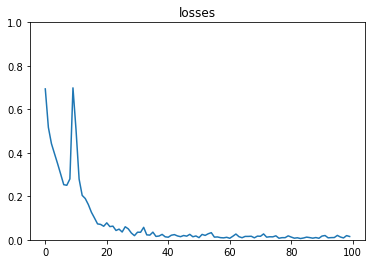

In [164]:
for i in range(10):
  plt.plot(losses[i])
plt.title('losses')
plt.ylim(0.0,1)